In [14]:
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
import logging
import pandas as pd
import json

import scipy as sp
#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


In [15]:
from ROOT import TF1, TMultiGraph, TGraphErrors, Math

In [16]:
om.__full_version__;
np.random.seed(1382398)

In [17]:
plt.rcParams["figure.dpi"] = 80
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['text.usetex'] = True

Import $\gamma$SF and NLD from Oslo Method

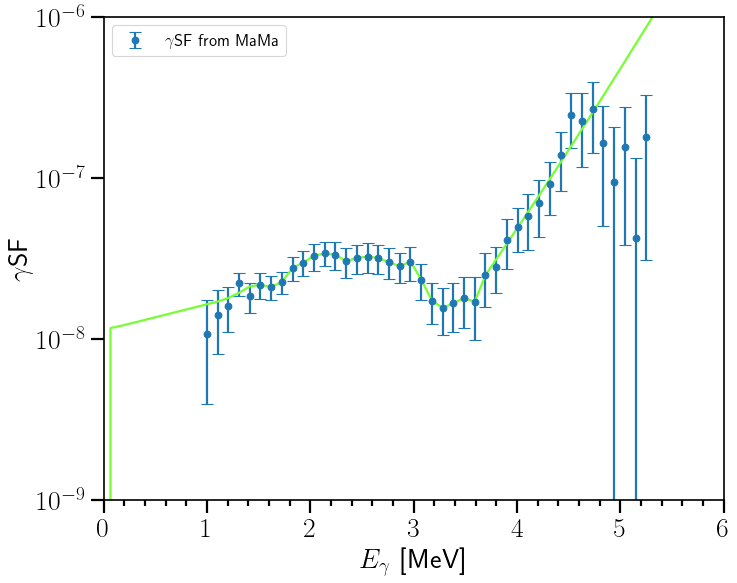

In [18]:
#reading files

#My normalization
strength_nrm = np.genfromtxt("../analysis/mama/strength.nrm") #experimental gamma strength function
discrete_levels = np.genfromtxt("../analysis/mama/rholev.cnt") #Discrete levels 
rhopaw = np.genfromtxt("../analysis/mama/rhopaw.cnt") #experimental level density
fermigas = np.genfromtxt("../analysis/mama/fermigas.cnt") #fermi gas extrapolation of nld
trans_raw = np.genfromtxt("../analysis/mama/transext.nrm") #gsf extrapolation

#Magne's normalization
#strength_nrm = np.genfromtxt("../analysis/mama/U233_12jan2021/U233_dRhoup/strength.nrm") #experimental gamma strength function
#discrete_levels = np.genfromtxt("../analysis/mama/U233_12jan2021/U233_dRhoup/rholev.cnt") #Discrete levels 
#rhopaw = np.genfromtxt("../analysis/mama/U233_12jan2021/U233_dRhoup/rhopaw.cnt") #experimental level density
#fermigas = np.genfromtxt("../analysis/mama/U233_12jan2021/U233_dRhoup/fermigas.cnt") #fermi gas extrapolation of nld
#trans_raw = np.genfromtxt("../analysis/mama/U233_12jan2021/U233_dRhoup/transext.nrm") #gsf extrapolation

#Magne's Normalization 
#strength_nrm = np.genfromtxt("../analysis/mama/U233_12jan2021/U233/strength.nrm") #experimental gamma strength function
#discrete_levels = np.genfromtxt("../analysis/mama/U233_12jan2021/U233/rholev.cnt") #Discrete levels 
#rhopaw = np.genfromtxt("../analysis/mama/U233_12jan2021/U233/rhopaw.cnt") #experimental level density
#fermigas = np.genfromtxt("../analysis/mama/U233_12jan2021/U233/fermigas.cnt") #fermi gas extrapolation of nld
#trans_raw = np.genfromtxt("../analysis/mama/U233_12jan2021/U233/transext.nrm") #gsf extrapolation

#splitting arrays into data and errors
strength_nrm_split = np.array_split(strength_nrm,2)
gsf_om = strength_nrm_split[0]
gsf_om_error = strength_nrm_split[1]

rhopaw_split = np.array_split(rhopaw, 2)
nld_om = rhopaw_split[0]
nld_om_error = rhopaw_split[1]

#variables for this experiment
a0 = -0.8671 #calibration constants
a1 = 0.1037
Sn = 5.762
rhoSn = 28.07e6
rhoSn_error = 7.02e6
Eg_min = 999.9
Eg_max = 5252


#making energy array for gsf
n_gsf = len(gsf_om)
energy_gsf_om = np.zeros(n_gsf)
for i in range(n_gsf):
    energy_gsf_om[i] = a0 + a1*i

#making energy array for nld
n_fermi = len(fermigas)
energy_nld_om = np.zeros(n_fermi)
for i in range(n_fermi):
    energy_nld_om[i] = a0 + a1*i

#finding cutting index for plotting CT extrapolation
n0_CT = np.argmin(abs(energy_nld_om-3.0))
n1_CT = np.argmin(abs(energy_nld_om-Sn-0.5))

n_trans_raw=len(trans_raw)
gsf_extrapolation=np.zeros(n_trans_raw)
energy_gsf_extrapolation=np.zeros(n_trans_raw)
for i in range(n_trans_raw):
    energy_gsf_extrapolation[i] = a0 + a1*i
    gsf_extrapolation[i] = trans_raw[i]/(2*3.14*energy_gsf_extrapolation[i]**3)
    

fig, ax = plt.subplots()

#mama-analysis
ax.errorbar(x=energy_gsf_om, y=gsf_om, yerr=gsf_om_error, marker='o', linestyle='', label=' $\gamma$SF from MaMa')

#extrapolation from mama-analysis
plt.plot(energy_gsf_extrapolation[:80], gsf_extrapolation[:80], color="#75FF33")

ax.set_ylim(1e-9, 1e-6)
ax.set_xlim(0, 6)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$E_\gamma$  [MeV]')
ax.set_ylabel('$\gamma$SF')
ax.legend(fontsize=15)

fig.show()


Import $\gamma$SF and NLD from OmPy

In [19]:
def read_ompy(datetime):
    """
    Read data from read_write_ompy() function in OmPy analysis.
    """
    path = '../analysis/OmPy/normalized_data/U233_2021-'+datetime+'/data_for_analysis.csv'
    dataFrame = pd.read_csv(path)

    energy_gsf = dataFrame.iloc[:,1]
    gsf_median = dataFrame.iloc[:,2]
    gsf_error = dataFrame.iloc[:,3]
    energy_nld = dataFrame.iloc[:,4]
    nld_median = dataFrame.iloc[:,5]
    nld_error = dataFrame.iloc[:,6]
    return energy_gsf, gsf_median, gsf_error, energy_nld, nld_median, nld_error


Import and convert experimental data from EXFOR

In [20]:
with open('exfor_data/u233_g_x.json') as K:
    data_U233 = json.load(K)
datasets_U233=data_U233["datasets"]




def cs_to_gsf(Eg, data):
    # input in MeV and milibarn -> use this conversion factor.
    exp = 8.6737e-8 # DOBBELTSJEKK TALLET! # pi**2 * hbar**2 * c**2
    return data*exp/Eg

def extract_JSON(data, x_i,y_i,yerror_i):
    """ Extracting data from input files from MAMA, adding them to useful arrays."""
    x = []; y = [] ; yerror = []

    for j in range(len(data)):
        y.append(data[j][y_i]) # MeV
        yerror.append(data[j][yerror_i]) # MeV
        x.append(data[j][x_i])

    x = np.array(x) ; y = np.array(y) ; yerror = np.array(yerror)
    return x,y,yerror



energy_exp1, gsf_exp1, gsf_exp1_error =  extract_JSON(datasets_U233[0]['data'], 5, 0, 1)
gsf_exp1 = cs_to_gsf(energy_exp1, gsf_exp1)
gsf_exp1_error = cs_to_gsf(energy_exp1, gsf_exp1_error)


"Does_it_work.cpp" 

Script to check the quality of the extracted
level density and strength function
by plotting exp. and calculated f.g. spectra
written by: ACL. June 7, 2012
Translated to Python January 2020 (tellefs)

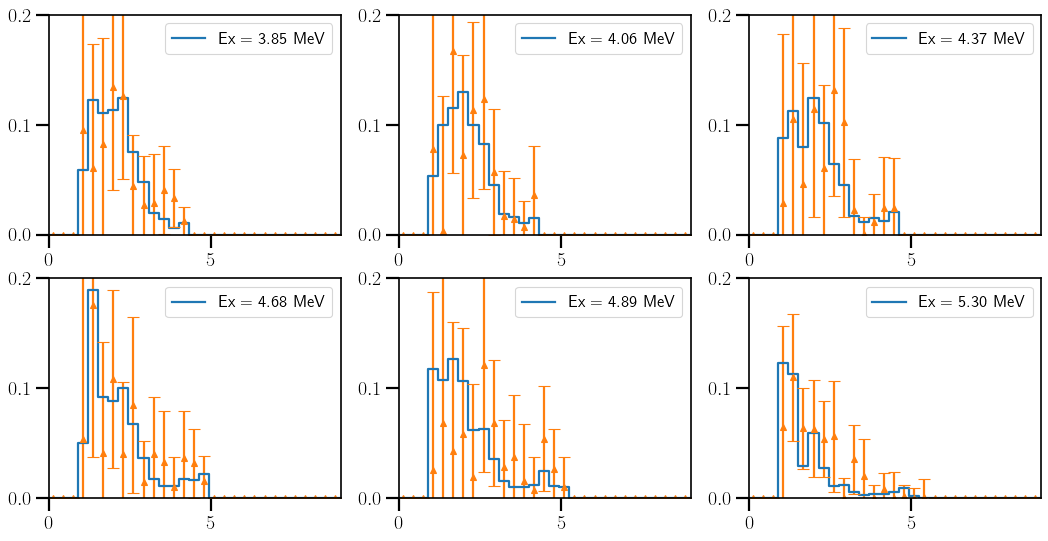

In [21]:
fg_theo_file = '../analysis/mama/fgteo.rsg'
fg_exp_file = '../analysis/mama/fg.rsg'
fg_exp_err_file = '../analysis/mama/fgerr.rsg'

#Magne's normalization
#fg_theo_file = '../analysis/mama/U233_12jan2021/U233_dRhoup/fgteo.rsg'
#fg_exp_file = '../analysis/mama/U233_12jan2021/U233_dRhoup/fg.rsg'
#fg_exp_err_file = '../analysis/mama/U233_12jan2021/U233_dRhoup/fgerr.rsg'


#set new rcParams. Need to reset after script to keep settings during program,
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['font.size'] = 18


def read_rsg(filename):
    infile = open(filename, 'r')
    matrix = []
    
    #extract calibration parameters:
    count = 0
    for line in infile:
        values = line.split()
        if not(values):
            count +=1
            continue
        elif line.startswith('!CALIBRATION'):
            values = line.split(',')
            x_cal = values[1:4]
            y_cal = values[4:7]
            for i in range(len(x_cal)):
                x_cal[i] = float(x_cal[i])*1e-3 #convert to float, convert from keV to MeV
                y_cal[i] = float(y_cal[i])*1e-3
            count+=1
        elif line.startswith('!DIMENSION'):
            values = line.split(':')
            x_dim = int(values[1].split(',')[0])
            y_dim = int(values[2])
            count+=1
        elif line.startswith('!'):
            count +=1
            continue
        else:
            for i in range(len(values)):
                values[i] = float(values[i])
            matrix.append(values)
            count +=1
            
    matrix = om.Matrix(matrix)
    
    infile.close()
    return matrix, x_cal, y_cal, x_dim, y_dim

fg_exp, x_cal_exp, y_cal_exp, x_dim_exp, y_dim_exp= read_rsg(fg_exp_file)
fg_exp_error, x_cal_exp_error, y_cal_exp_error, x_dim_exp_error, y_dim_exp_error = read_rsg(fg_exp_err_file)
fg_theo, x_cal_theo, y_cal_theo, x_dim_theo, y_dim_theo = read_rsg(fg_theo_file)

bin1, bin2, bin3, bin4, bin5, bin6 = 13, 14, 15, 16, 17, 18

bins = [45, 47, 50, 53, 55, 59,]

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i in range(len(bins)):
    bin_no = bins[i]
    fg_theo_copy = fg_theo.copy()
    fg_theo_copy.cut('Ex', bin_no, bin_no+2)
    fg_theo_copy.Eg = x_cal_theo[0] + x_cal_theo[1]*fg_theo_copy.Eg + x_cal_theo[2]*fg_theo_copy.Eg**2
    fg_theo_copy.Ex = y_cal_theo[0] + y_cal_theo[1]*fg_theo_copy.Ex + y_cal_theo[2]*fg_theo_copy.Ex**2
    theo_y, theo_x = fg_theo_copy.projection('Eg')
    
    
    fg_exp_copy = fg_exp.copy()
    fg_exp_copy.cut('Ex', bin_no, bin_no+2)
    fg_exp_copy.Eg = x_cal_exp[0] + x_cal_exp[1]*fg_exp_copy.Eg + x_cal_exp[2]*fg_exp_copy.Eg**2
    fg_exp_copy.Ex = y_cal_exp[0] + y_cal_exp[1]*fg_exp_copy.Ex + y_cal_exp[2]*fg_exp_copy.Ex**2
    exp_y, exp_x = fg_exp_copy.projection('Eg');
    
    fg_exp_error_copy = fg_exp_error.copy()
    fg_exp_error_copy.cut('Ex', bin_no, bin_no+2)
    fg_exp_error_copy.Eg = x_cal_exp_error[0] + x_cal_exp_error[1]*fg_exp_error_copy.Eg + x_cal_exp_error[2]*fg_exp_error_copy.Eg**2
    fg_exp_error_copy.Ex = y_cal_exp_error[0] + y_cal_exp_error[1]*fg_exp_copy.Ex + y_cal_exp_error[2]*fg_exp_error_copy.Ex**2
    exp_err_y, exp_err_x = fg_exp_error_copy.projection('Eg');
    
    #cut arrays to show lesser points
    theo_y = theo_y[0:-1:3]
    theo_x = theo_x[0:-1:3]
    exp_y = exp_y[0:-1:3]
    exp_x = exp_x[0:-1:3]
    exp_err_y = exp_err_y[0:-1:3]
    exp_err_x = exp_err_x[0:-1:3]
    
    current_Ex = y_cal_theo[0] + y_cal_theo[1]*(bin_no+0.5) + y_cal_theo[2]*(bin_no+0.5)**2
    axes[i].step(theo_x, theo_y, where='mid', label='Ex = %.2f MeV'%current_Ex)
    
    
    axes[i].errorbar(exp_x, exp_y, yerr=exp_err_y, marker='^', linestyle='')
    axes[i].legend(fontsize=15)
    
    
    
    axes[i].set_xlim(0, 9)
    axes[i].set_ylim(0, 0.2)
    
fig.show()


#reset rcParams
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25

Comparison with theorietical GEDR models (Giant Electric Dipole Resonance)

Fit to resonances of gsf

In [22]:
#Declaring fit functions

def SLo(E_gamma, Gamma_r, E_r, sigma_r):
    """
    Standard Lorentzian
    E_gamma = The gamma-energy on the x-axis
    Gamma_r = 
    E_r =
    sigma_r =
    """
    factor = 8.674e-8
    denominator = (E_gamma**2 - E_r**2)**2 + (Gamma_r**2 * E_gamma**2)
    
    return factor * sigma_r * Gamma_r**2 * E_gamma / denominator

def Gamma_k(E_gamma, Gamma_r, E_r, T_f):
    """
    E_gamma = The gamma-energy on the x-axis
    Gamma_r = 
    E_r =
    sigma_r =
    """
    return Gamma_r * (E_gamma**2 + (2*np.pi*T_f)**2) / (E_r**2)

def GLo(E_gamma, Gamma_r, E_r, sigma_r, T_f):
    """
    Generalized Lorentzian
    E_gamma = The gamma-energy on the x-axis
    Gamma_r = 
    E_r =
    sigma_r = 
    T_f = 
    """
    factor = 8.674e-8
    A = E_gamma * Gamma_k(E_gamma, Gamma_r, E_r, T_f) / ( (E_gamma**2 - E_r**2)**2 + (E_gamma * Gamma_k(E_gamma, Gamma_r, E_r, T_f))**2 )
    B = 0.7 * Gamma_k(E_gamma, Gamma_r, E_r, T_f) / (E_r**3)
    
    GLo = factor * sigma_r * Gamma_r * (A + B)
    return GLo

def FitFunctionStrength(x, par):
    """
    All different resonances and parameters of the fit to the experimental strength function
    GLo1 and GLo2 parameters are for the two peaks of the GDR
    pyg1 and pyg2 are for the two peaks of the pygme resonances
    SR are for the Scissor Resonance
    
    E_gamma = The gamma-energy on the x-axis
    Gamma_r_* = 
    E_r_* = 
    sigma_r_* = 
    T_f = Constant temperature for the GLo fits.
    
    """
    E_gamma = x[0]
    
    Gamma_r_GLo1 = par[0]
    E_r_GLo1 = par[1]
    sigma_r_GLo1 = par[2]
    
    Gamma_r_GLo2 = par[3]
    E_r_GLo2 = par[4]
    sigma_r_GLo2 = par[5]
    
    T_f_GLo = par[6]
    
    Gamma_pyg1 = par[7]
    E_pyg1 = par[8]
    sigma_pyg1 = par[9]
    
    Gamma_pyg2 = par[10]
    E_pyg2 = par[11]
    sigma_pyg2 = par[12]
    
    Gamma_SR = par[13]
    E_SR = par[14]
    sigma_SR = par[15]
    
    GLo1 = GLo(E_gamma, Gamma_r_GLo1, E_r_GLo1, sigma_r_GLo1, T_f)
    GLo2 = GLo(E_gamma, Gamma_r_GLo2, E_r_GLo2, sigma_r_GLo2, T_f)
    SLo_pyg1 = SLo(E_gamma, Gamma_pyg1, E_pyg1, sigma_pyg1)
    SLo_pyg2 = SLo(E_gamma, Gamma_pyg2, E_pyg2, sigma_pyg2)
    SLo_SR = SLo(E_gamma, Gamma_SR, E_SR, sigma_SR)
    
    return GLo1 + GLo2 + SLo_pyg1 + SLo_pyg2 + SLo_SR

def FitFunctionE1(x, par):
    E_gamma = x[0]
    Gamma_r_GLo1 = par[0]
    E_r_GLo1 = par[1]
    sigma_r_GLo1 = par[2]
    Gamma_r_GLo2 = par[3]
    E_r_GLo2 = par[4]
    sigma_r_GLo2 = par[5]
    T_f = par[6]
    return GLo(E_gamma, Gamma_r_GLo1, E_r_GLo1, sigma_r_GLo1, T_f) + GLo(E_gamma, Gamma_r_GLo2, E_r_GLo2, sigma_r_GLo2, T_f)

def FitPygmy(x, par):
    E_gamma = x[0]
    Gamma = par[0]
    E = par[1]
    sigma = par[2]
    return SLo(E_gamma, Gamma, E, sigma)

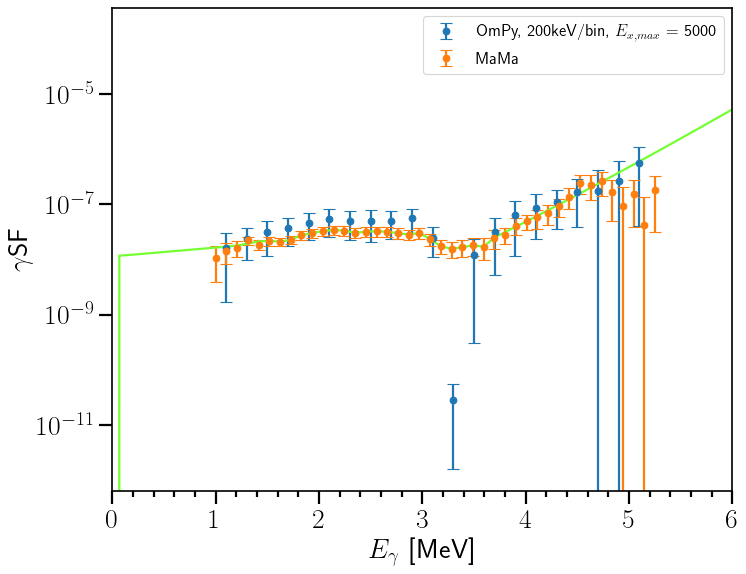

In [23]:
fig, ax = plt.subplots()


#extract ompy data via function above
datetime = '01-21_12:12:50'
energy_gsf_ompy, gsf_ompy_median, gsf_ompy_error, energy_nld_ompy, nld_ompy_median, nld_ompy_error = read_ompy(datetime)
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, marker='o', linestyle='', label='OmPy, 200keV/bin, $E_{x, max}$ = 5000')

#mama-analysis
ax.errorbar(x=energy_gsf_om, y=gsf_om, yerr=gsf_om_error, marker='o', linestyle='', label='MaMa')

#extrapolation from mama-analysis
plt.plot(energy_gsf_extrapolation[:80], gsf_extrapolation[:80], color="#75FF33")

#ax.set_ylim(1e-9, 1e-6)
ax.set_xlim(0, 6)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$E_\gamma$  [MeV]')
ax.set_ylabel('$\gamma$SF')
ax.legend(fontsize=15)

fig.show()

Fitting strength function with PyROOT

In [24]:
#Define parameters & start values for the GLO
E_r_GLo1 = 11.4 # centroid (MeV)
Gamma_r_GLo1 = 2.0 # width (MeV)
sigma_r_GLo1 = 300 # peak cross section (mb)
E_r_GLo2 = 14.0 # centroid (MeV)
Gamma_r_GLo2 = 4.3 # width (MeV)
sigma_r_GLo2 = 480 # peak cross section (mb)
T_f    = 0.015 #constant temperature of final states (MeV)

#START VALUES pygmy resonance 1
E_pyg1 = 4.5 # Pygmy centroid (MeV)
Gamma_pyg1 = 0.4 # Width (MeV)
sigma_pyg1 = 5.0 #peak cross section (mb)

#START VALUES pygmy 2/spinflip resonance
E_pyg2 = 7.0 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_pyg2 = 1.5 #Width (MeV)
sigma_pyg2 = 20.0 #peak cross section (mb)

#START VALUES Pygmy scissors resonance
E_SR = 2.5 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_SR = 1.5 #Width (MeV)
sigma_SR = 1.0 #peak cross section (mb)

parameter_array_E1 = np.asarray([Gamma_r_GLo1, E_r_GLo1, sigma_r_GLo1, 
                                 Gamma_r_GLo2, E_r_GLo2, sigma_r_GLo2, T_f])

parameter_array_M1 = np.asarray([Gamma_pyg2, E_pyg2, sigma_pyg2])


#TGraphErrors of OmPy data
energy_gsf_ompy_error = np.zeros(len(energy_gsf_ompy))
gsf_ompy = TGraphErrors(len(energy_gsf_ompy), np.asarray(energy_gsf_ompy), np.asarray(gsf_ompy_median), np.asarray(energy_gsf_ompy_error), np.asarray(gsf_ompy_error))

#TGraphErrors of Std. Oslo data
energy_gsf_om_error = np.zeros(len(energy_gsf_om))
gsf_om_ROOT = TGraphErrors(len(energy_gsf_om), np.asarray(energy_gsf_om), np.asarray(gsf_om), np.asarray(energy_gsf_om_error), np.asarray(gsf_om_error))

#TGrapgErrors of Berman-data
energy_exp1_error = np.zeros(len(energy_exp1))
berman_233_gdrexp = TGraphErrors(27, energy_exp1, gsf_exp1, energy_exp1_error, gsf_exp1_error)

#Fit of the GLO model for the GDR part
xmin_GDR = 9.5
xmax_GDR = 18
no_of_parameters_GDR = 7
fit_strength_E1 = TF1('fit_strength_E1', FitFunctionE1, xmin_GDR, xmax_GDR, no_of_parameters_GDR)
fit_strength_E1.SetParameters(parameter_array_E1)


#setting limits for parameter #6 = T_f
fit_strength_E1.SetParLimits(6, 0.01, 0.02)

#setting limits for parameter #3 = Gamma_r_GLo2
fit_strength_E1.SetParLimits(3, 0.1, 10.)

#Defining GDR Data
GDR_data = TMultiGraph()
GDR_data.Add(berman_233_gdrexp, "P")


#Math.MinimizerOptions.SetDefaultMaxFunctionCalls(10000)
#Fitting GDR data
GDR_data.Fit(fit_strength_E1, 'RM+')



xmin_pyg2 = 3.
xmax_pyg2 = 12.
no_of_parameters_pyg2 = 3
fit_strength_M1 = TF1('fit_strength_M1', FitPygmy, xmin_pyg2, xmax_pyg2, no_of_parameters_pyg2)
fit_strength_M1.SetParameters(parameter_array_M1)
fit_strength_M1.FixParameter(1, E_pyg2)
fit_strength_M1.FixParameter(0, Gamma_pyg2)

#Kopecky data?
fEx = np.asarray([12.14E-08])
fEerr = np.asarray([3.92E-08])
fEene = np.asarray([3.9])
fEeneerr = np.asarray([0.00])
        
fMx = np.asarray([2.11E-08])
fMerr = np.asarray([0.78E-08])
fMene = np.asarray([4.4])
fMeneerr = np.asarray([0.0])
fE = TGraphErrors(1,fEene,fEx,fEeneerr,fEerr)
fM = TGraphErrors(1,fMene,fMx,fEeneerr,fMerr)

M1_data = TMultiGraph()
M1_data.Add(fM)
M1_data.Fit(fit_strength_M1, 'RM+')


Gamma_r_GLo1 = fit_strength_E1.GetParameter(0)
E_r_GLo1 = fit_strength_E1.GetParameter(1)
sigma_r_GLo1 = fit_strength_E1.GetParameter(2)

Gamma_r_GLo2 = fit_strength_E1.GetParameter(3)
E_r_GLo2 = fit_strength_E1.GetParameter(4)
sigma_r_GLo2 = fit_strength_E1.GetParameter(5)

T_f = fit_strength_E1.GetParameter(6)

Gamma_pyg2 = fit_strength_M1.GetParameter(0)
E_pyg2 = fit_strength_M1.GetParameter(1)
sigma_pyg2 = fit_strength_M1.GetParameter(2)

xmin_tot = 1.1
xmax_tot = 18.
no_of_parameters_tot = 16
fit_strength = TF1('fit_strength', FitFunctionStrength, xmin_tot, xmax_tot, no_of_parameters_tot)
parameter_array_full = np.asarray([Gamma_r_GLo1, E_r_GLo1, sigma_r_GLo1,
                                  Gamma_r_GLo2, E_r_GLo2, sigma_r_GLo2, T_f,
                                  Gamma_pyg1, E_pyg1, sigma_pyg1,
                                  Gamma_pyg2, E_pyg2, sigma_pyg2,
                                  Gamma_SR, E_SR, sigma_SR])

fit_strength.SetParameters(parameter_array_full)
fit_strength.FixParameter(1, E_r_GLo1)
fit_strength.FixParameter(4, E_r_GLo2)
fit_strength.SetParLimits(6, 0.1, 0.2)


#Defining all data (Berman and OmPy)
OmPy_and_GDR_data = TMultiGraph()
OmPy_and_GDR_data.Add(berman_233_gdrexp, "P")
OmPy_and_GDR_data.Add(gsf_ompy, "P")

OsloSTD_and_GDR_data = TMultiGraph()
OsloSTD_and_GDR_data.Add(berman_233_gdrexp, "P")
OsloSTD_and_GDR_data.Add(gsf_om_ROOT, "P")

OmPy_and_GDR_data.Fit(fit_strength, 'S')
#OsloSTD_and_GDR_data.Fit(fit_strength, 'RM+')


 FCN=77.9485 FROM HESSE     STATUS=OK             50 CALLS        1127 TOTAL
                     EDM=2.88206e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.72191e+00   1.07348e-01   2.06691e-05   2.11043e-03
   2  p1           1.41639e+01   2.48376e-02   1.18729e-05   1.51975e-02
   3  p2           1.13882e+03   2.34118e+01   5.82554e-03   3.46781e-05
   4  p3           3.40828e+00   1.46017e-01   4.98173e-06   1.91467e-02
   5  p4           1.15128e+01   5.78854e-02   1.05376e-05   4.24945e-03
   6  p5           7.20184e+02   1.83868e+01   3.09964e-03   2.67960e-05
   7  p6           2.00000e-02   6.49723e-03   1.19322e-02** at limit **
 FCN=2.8048e-20 FROM HESSE     STATUS=OK              5 CALLS          25 TOTAL
                     EDM=5.60963e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER             

Error in <TList::Delete>: A list is accessing an object (0x7f8b47164ae0) already deleted (list name = TList)
Error in <TList::Delete>: A list is accessing an object (0x7f8b47164ae0) already deleted (list name = TList)
Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 
Warning in <Fit>: Abnormal termination of minimization.


[ 1.73289188  6.74210702 19.46068552]


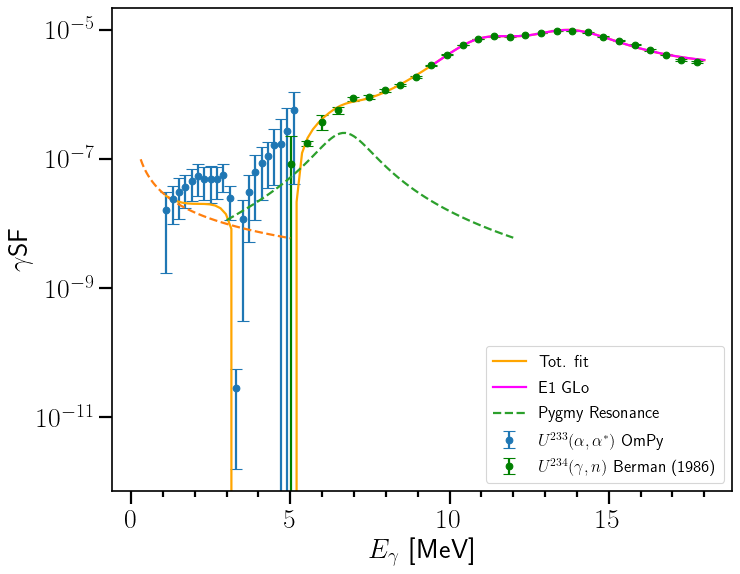

In [36]:
fig, ax = plt.subplots()

#This experiment
#ax.errorbar(x=energy_gsf_om, y=gsf_om, yerr=gsf_om_error, marker='o', linestyle='', label='Oslo Method (Std.)')
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, marker='o', linestyle='', label='$U^{233}(\\alpha,\\alpha^*)$ OmPy')


#Experimental: Berman 1986
ax.errorbar(energy_exp1, gsf_exp1, yerr=gsf_exp1_error, x_err=None, fmt="o", color='green', label="$U^{234}(\gamma,n)$ Berman (1986)")


#Plotting total fit
fitted_parameters = np.zeros(no_of_parameters_tot)
for i in range(no_of_parameters_tot):
    fitted_parameters[i] = fit_strength.GetParameters()[i]
x_plot = [np.linspace(xmin_tot, xmax_tot, 100)]
y_plot = FitFunctionStrength(x_plot, fitted_parameters)
ax.plot(x_plot[0], y_plot, color='orange', label='Tot. fit')


#plotting fit of Scissors Resonance
fitted_parameters_SR = np.zeros(3)
fitted_parameters_SR[0] = fitted_parameters[13]
fitted_parameters_SR[1] = fitted_parameters[14]
fitted_parameters_SR[2] = fitted_parameters[15]
x_plot_SR = [np.linspace(0.3, 5, 100)]
y_plot_SR = FitPygmy(x_plot_SR, fitted_parameters_SR)
ax.plot(x_plot_SR[0], y_plot_SR, '--')

#Plotting fit of GDR
fitted_parameters_E1 = np.zeros(no_of_parameters_GDR)
for i in range(no_of_parameters_GDR):
    fitted_parameters_E1[i] = fit_strength_E1.GetParameters()[i]
x_plot_E1 = [np.linspace(xmin_GDR, xmax_GDR, 100)]
y_plot_E1 = FitFunctionE1(x_plot_E1, fitted_parameters_E1)
ax.plot(x_plot_E1[0], y_plot_E1, color='magenta', label='E1 GLo')

#plotting fit of Pyg2
fitted_parameters_pyg2 = np.zeros(no_of_parameters_pyg2)
fitted_parameters_pyg2[0] = fitted_parameters[10]
fitted_parameters_pyg2[1] = fitted_parameters[11]
fitted_parameters_pyg2[2] = fitted_parameters[12]
print(fitted_parameters_pyg2)

x_plot_pyg2 = [np.linspace(3, 12, 100)]
y_plot_pyg2 = FitPygmy(x_plot_pyg2, fitted_parameters_pyg2)
ax.plot(x_plot_pyg2[0], y_plot_pyg2, '--', label='Pygmy Resonance')



#ax.set_ylim(1e-8, 1e-5)
#ax.set_xlim(0, 7)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$E_\gamma$  [MeV]')
ax.set_ylabel('$\gamma$SF')
ax.legend(fontsize=15)

fig.show()

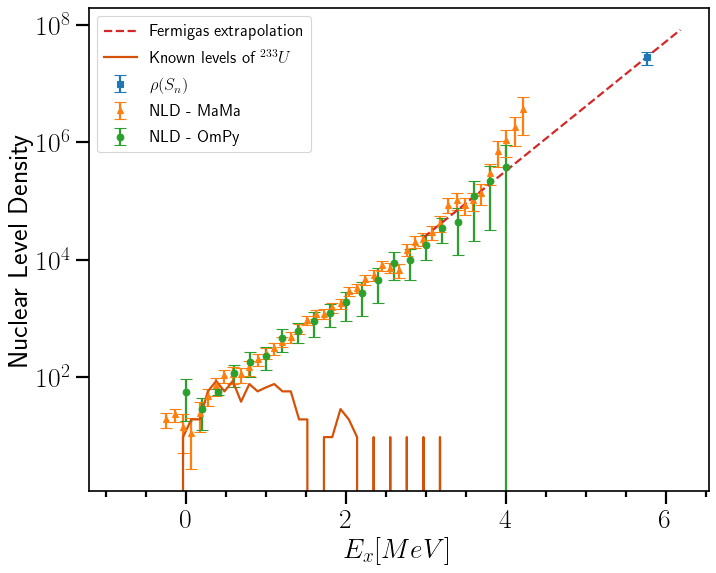

In [26]:
fig, ax = plt.subplots()

#plotting neutron separation energy
ax.errorbar(x=Sn, y=rhoSn, yerr=rhoSn_error, marker='s', linestyle='', label='$\\rho(S_n)$')

#plotting mama nld
ax.errorbar(x=energy_nld_om[:len(nld_om)], y=nld_om, yerr=nld_om_error, marker='^', linestyle='', label='NLD - MaMa')

#plotting ompy nld
ax.errorbar(x=energy_nld_ompy, y=nld_ompy_median, yerr=nld_ompy_error, marker='o', linestyle='', label = 'NLD - OmPy')

#plotting fermigas extrapolation from mama
ax.plot(energy_nld_om[n0_CT:n1_CT], fermigas[n0_CT:n1_CT], linestyle='--', label='Fermigas extrapolation')

#plotting discrete levels
plt.plot(energy_nld_om[:len(discrete_levels)], discrete_levels, color="#D65108", label='Known levels of $^{233}U$')

ax.legend(fontsize=15)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$E_x[MeV]$')
ax.set_ylabel('Nuclear Level Density')
#ax.set_xlim(-1, 10)
#ax.set_ylim(1e1, 1e10)

fig.show()
